In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.pipeline import make_pipeline
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [17]:
dataset_path = "./dataset"

In [18]:
# Configuration
MOVES = [
    "center",
    "left",
    "right",
    "up",
    "down",
    "downleft",
    "downright",
    "upleft",
    "upright",
    "updown",
    "leftright",
]
SAMPLE_RATE = 16000  # Standard sample rate for audio
WINDOW_SIZES = [1, 5, "full"]  # in seconds - 3 required window sizes

In [19]:
# Sample function to resample the input audio to 16kHz
def load_audio_16k(path):
    audio, sr = librosa.load(path, SAMPLE_RATE=16000)  # Resample to 16 kHz
    return audio, sr

##Feature Extraction

notes: wave 1 and wave 2 cross correlation

In [20]:
from features import (
    extract_all_features_with_xcorr,
)
from stomp_detector import StompDetector
from file_stream import FileStream

##Data Processing

In [21]:
def list_audio_files(base_path):
    """List all valid audio files in dataset directory."""
    audio_files = []
    if os.path.exists(base_path):
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith(".wav"):
                    # Extract move from filename (last part before .wav)
                    basename = os.path.splitext(file)[0]
                    # Get the last underscore-separated part as the move
                    parts = basename.split("_")
                    move = parts[-1]
                    if move in MOVES:
                        audio_files.append(os.path.join(root, file))
    return audio_files


def load_and_extract_features_xcorr(audio_files):
    """
    Load audio files, split them into individual stomps, and extract features
    for EACH stomp instead of one feature vector per whole file.
    """
    X, y, metadata = [], [], []

    # Parameters for streaming
    window_ms = 200
    step_ms = 100
    sr = SAMPLE_RATE


    window_frames = int((window_ms / 1000.0) * sr)
    step_frames = int((step_ms / 1000.0) * sr)
    channels = 2  # Assuming stereo

    for file in audio_files:
        try:
            # Use the stomp detector with streaming
            detector = StompDetector(sr=sr, energy_threshold=7.0)
            audio_buffer = np.zeros((window_frames, channels), dtype=np.float32)

            stomps = []

            # Stream the file
            stream_ctx = FileStream(file, step_frames)

            with stream_ctx as stream:
                while not stream.finished:
                    chunk, overflow = stream.read(step_frames)

                    # Update rolling buffer
                    audio_buffer = np.roll(audio_buffer, -step_frames, axis=0)
                    audio_buffer[-step_frames :] = chunk

                    # Detect on the full window
                    detected_stomps = detector.detect(audio_buffer)
                    stomps.extend(detected_stomps)

            if len(stomps) == 0:
                exit(1)
                continue

            basename = os.path.basename(file)
            basename_no_ext = os.path.splitext(basename)[0]
            move = basename_no_ext.split("_")[-1]

            move_idx = MOVES.index(move)

            for i, stomp in enumerate(stomps):
                features = extract_all_features_with_xcorr(stomp, SAMPLE_RATE)

                X.append(features)
                y.append(move_idx)
                metadata.append(
                    {
                        "file": basename,
                        "move": move,
                        "stomp_idx": i,
                        "n_samples": len(stomp),
                    }
                )

        except Exception as e:
            print(f"Skipping {file} due to error: {e}")
            import traceback
            traceback.print_exc()

    return np.array(X), np.array(y), pd.DataFrame(metadata)

In [22]:
def prepare_data(X, y, test_size=0.2, random_state=42):
    """
    Prepares data for training and testing: scales features and performs train-test split.
    """

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return (
        X_train,
        X_test,
        y_train,
        y_test,
    )

In [23]:
audio_files = list_audio_files(dataset_path)
X, y, metadata = load_and_extract_features_xcorr(audio_files)
print(X.shape)

(2251, 48)


In [24]:
unique, counts = np.unique(y, return_counts=True)
for i, count in zip(unique, counts):
    print(f"{MOVES[i]}: {count}")

center: 122
left: 248
right: 385
up: 318
down: 316
downleft: 143
downright: 153
upleft: 135
upright: 111
updown: 161
leftright: 159


In [25]:
X_train, X_test, y_train, y_test = prepare_data(X, y)

In [26]:
from sklearn.model_selection import GridSearchCV

def make_and_train_classifier(X, y):
    search_params = {
        "mlpclassifier__hidden_layer_sizes": [(256, 256), (256, 128), (128, 128), (64, 64), (32, 32), (256, 64), (512, 512)],
        "mlpclassifier__alpha": [1e-2, 1e-3, 1e-4, 1e-5]
    }


    clr = MLPClassifier(
        activation="relu",
        solver="adam",
        batch_size=32,
        learning_rate="adaptive",
        max_iter=300,
        early_stopping=True,  # use a validation split internally
        n_iter_no_change=10,
        random_state=42,
    )

    pipeline = make_pipeline(StandardScaler(), clr)
    cv = GridSearchCV(pipeline, search_params, n_jobs=-1)

    cv.fit(X, y)
    return cv

## Simple Version

In [27]:
# We only care about these directions
BASIC_MOVES = ["left", "right", "up", "down"]

# Get their indices in the full MOVES list
basic_move_indices = [MOVES.index(m) for m in BASIC_MOVES]

# Keep only samples where the label is one of these 5
train_mask = np.isin(y_train, basic_move_indices)
test_mask = np.isin(y_test, basic_move_indices)

X_train_basic = X_train[train_mask]
y_train_basic = y_train[train_mask]
X_test_basic = X_test[test_mask]
y_test_basic = y_test[test_mask]

print("5-direction training examples:", X_train_basic.shape[0])
print("5-direction test examples:", X_test_basic.shape[0])

label_map = {old_idx: new_idx for new_idx, old_idx in enumerate(basic_move_indices)}
inv_label_map = {v: k for k, v in label_map.items()}  # if you want to go back later

y_train_basic_remap = np.array([label_map[i] for i in y_train_basic])
y_test_basic_remap = np.array([label_map[i] for i in y_test_basic])

print("Unique remapped train labels:", np.unique(y_train_basic_remap))
print("Unique remapped test labels:", np.unique(y_test_basic_remap))

5-direction training examples: 1013
5-direction test examples: 254
Unique remapped train labels: [0 1 2 3]
Unique remapped test labels: [0 1 2 3]



=== 5-Direction Neural Network (MLP) Performance ===
Test Accuracy (5 classes): 0.8583

=== Classification Report (5 classes) ===
              precision    recall  f1-score   support

        left       0.86      0.84      0.85        50
       right       0.89      0.83      0.86        77
          up       0.83      0.89      0.86        64
        down       0.86      0.87      0.87        63

    accuracy                           0.86       254
   macro avg       0.86      0.86      0.86       254
weighted avg       0.86      0.86      0.86       254



<Figure size 600x500 with 0 Axes>

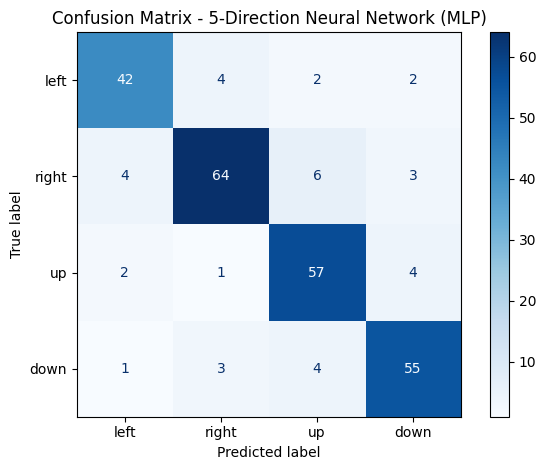

,steps,"[('standardscaler', ...), ('mlpclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(512, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


In [ ]:
# Define a separate neural network for 5 basic directions
mlp_basic = make_and_train_classifier(X_train_basic, y_train_basic_remap)

# Predict on the filtered test set
y_pred_basic = mlp_basic.predict(X_test_basic)

# Evaluate performance
nn_basic_accuracy = accuracy_score(y_test_basic_remap, y_pred_basic)
print("\n=== 5-Direction Neural Network (MLP) Performance ===")
print(f"Test Accuracy (5 classes): {nn_basic_accuracy:.4f}")

print("\n=== Classification Report (5 classes) ===")
print(classification_report(y_test_basic_remap, y_pred_basic, target_names=BASIC_MOVES))

# Confusion matrix for the 5 directions
cm_basic = confusion_matrix(y_test_basic_remap, y_pred_basic)

plt.figure(figsize=(6, 5))
disp_basic = ConfusionMatrixDisplay(
    confusion_matrix=cm_basic, display_labels=BASIC_MOVES
)
disp_basic.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix - 5-Direction Neural Network (MLP)")
plt.tight_layout()
plt.show()
mlp_basic.fit(
    np.concat([X_train_basic, X_test_basic]),
    np.concat([y_train_basic_remap, y_test_basic_remap]),
)

## Only left or right

2-direction training examples: 506
2-direction test examples: 127
Unique remapped train labels: [0 1]
Unique remapped test labels: [0 1]

=== 2-Direction Neural Network (MLP) Performance ===
Test Accuracy (2 classes): 0.9528

=== Classification Report (2 classes) ===
              precision    recall  f1-score   support

        left       0.91      0.98      0.94        50
       right       0.99      0.94      0.96        77

    accuracy                           0.95       127
   macro avg       0.95      0.96      0.95       127
weighted avg       0.96      0.95      0.95       127


=== 2-Direction Neural Network (MLP) Performance ===
Test Accuracy (2 classes): 0.9528

=== Classification Report (2 classes) ===
              precision    recall  f1-score   support

        left       0.91      0.98      0.94        50
       right       0.99      0.94      0.96        77

    accuracy                           0.95       127
   macro avg       0.95      0.96      0.95       127
we

<Figure size 600x500 with 0 Axes>

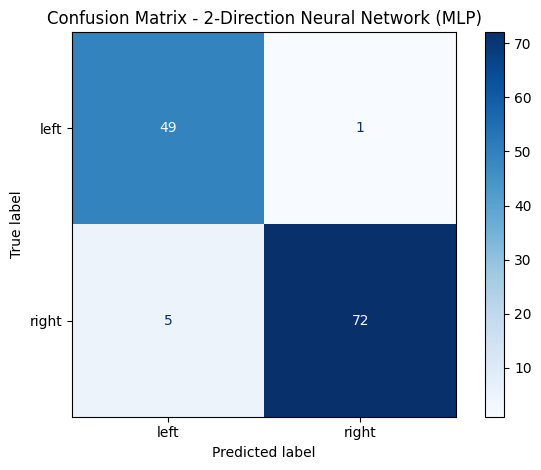

,steps,"[('standardscaler', ...), ('mlpclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(512, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.01


In [ ]:
# We only care about these directions
SUPER_BASIC_MOVES = ["left", "right"]

# Get their indices in the full MOVES list
basic_move_indices = [MOVES.index(m) for m in SUPER_BASIC_MOVES]

# Keep only samples where the label is one of these 2
train_mask = np.isin(y_train, basic_move_indices)
test_mask = np.isin(y_test, basic_move_indices)

X_train_lr = X_train[train_mask]
y_train_lr = y_train[train_mask]
X_test_lr = X_test[test_mask]
y_test_lr = y_test[test_mask]

print("2-direction training examples:", X_train_lr.shape[0])
print("2-direction test examples:", X_test_lr.shape[0])

label_map = {old_idx: new_idx for new_idx, old_idx in enumerate(basic_move_indices)}
inv_label_map = {v: k for k, v in label_map.items()}  # if you want to go back later

y_train_lr_remap = np.array([label_map[i] for i in y_train_lr])
y_test_lr_remap = np.array([label_map[i] for i in y_test_lr])

print("Unique remapped train labels:", np.unique(y_train_lr_remap))
print("Unique remapped test labels:", np.unique(y_test_lr_remap))

# Define a separate neural network for 5 basic directions
mlp_only_left_right = make_and_train_classifier(X_train_lr, y_train_lr_remap)

# Predict on the filtered test set
y_pred_lr = mlp_only_left_right.predict(X_test_lr)

# Evaluate performance
nn_lr_accuracy = accuracy_score(y_test_lr_remap, y_pred_lr)
print("\n=== 2-Direction Neural Network (MLP) Performance ===")
print(f"Test Accuracy (2 classes): {nn_lr_accuracy:.4f}")

print("\n=== Classification Report (2 classes) ===")
print(classification_report(y_test_lr_remap, y_pred_lr, target_names=SUPER_BASIC_MOVES))

# Confusion matrix for the 2 directions
cm_lr = confusion_matrix(y_test_lr_remap, y_pred_lr)

plt.figure(figsize=(6, 5))
disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr, display_labels=SUPER_BASIC_MOVES
)
disp_lr.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix - 2-Direction Neural Network (MLP)")
plt.tight_layout()
plt.show()

mlp_only_left_right.fit(
    np.concat([X_train_lr, X_test_lr]), np.concat([y_train_lr_remap, y_test_lr_remap])
)

In [30]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


def save_mlp_with_scaler_to_onnx(model, onnx_path):
    """
    Wraps (scaler → model) in a Pipeline and saves as ONNX.
    """

    # Number of input features
    n_features = model.n_features_in_

    initial_type = [("input", FloatTensorType([None, n_features]))]

    onnx_model = convert_sklearn(model, initial_types=initial_type)

    with open(onnx_path, "wb") as f:
        f.write(onnx_model.SerializeToString())

    print(f"Saved ONNX model to {onnx_path}")


# 2) 5-direction model (center/left/right/up/down)
save_mlp_with_scaler_to_onnx(
    model=mlp_basic, onnx_path="./models/mlp_five_directions.onnx"
)

# 3) Left/right-only model
save_mlp_with_scaler_to_onnx(
    model=mlp_only_left_right, onnx_path="./models/mlp_left_right.onnx"
)

Saved ONNX model to ./models/mlp_five_directions.onnx
Saved ONNX model to ./models/mlp_left_right.onnx
